In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
import pubchempy as pcp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from jcamp import JCAMP_calc_xsec, JCAMP_reader

In [2]:
PATH = "jdx"
SMILES = []
spectra = []

In [4]:
def closest(myList, myNumber):
    #Find num in list closest to mynum, used in preprocess
    from bisect import bisect_left
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before
    
def process_file(filename):
    """Convert spectrum units to wavenumbers (x) and transmittance (y), and interpolate any missing coordinates, then return a list of transmitances"""
    #TODO: ask if nitrogen dilution matters at all
    #MIN: 450, MAX: 4914, increments of 2
    spectrum = JCAMP_reader(filename)
    try:
        JCAMP_calc_xsec(spectrum, skip_nonquant = False)
        if(spectrum["state"] != "gas" and spectrum['state'] != "GAS"):
            return(False)
    except:
        return(False)
    #plt.plot()


def why_bad(filename):
    spectrum = JCAMP_reader(filename)
    try:
        JCAMP_calc_xsec(spectrum, skip_nonquant = False)
        if(spectrum["state"] != "gas" and spectrum['state'] != "GAS"):
            return(spectrum["state"])
    except:
        return("Couldn't read file")
    pass

In [6]:
bad, reason_bad = 0, []
for spectrafile in tqdm(os.listdir(PATH)):
    try:
        spectrum = process_file(PATH + "/" + spectrafile)
    except:
        bad += 1
        continue
    if (type(spectrum) != np.ndarray):
        reason_bad.append(why_bad(PATH + "/" + spectrafile))
        continue
    #Get the smiles out of the mol using rdkit
    molfile = "mol/" + spectrafile[:-7] + ".mol"
    mol = Chem.MolFromMolFile(molfile)
    try:
        sm = Chem.MolToSmiles(mol)
    except:
        continue  
    
    if(sm != ""):
        spectra.append(spectrum)
        SMILES.append(sm)
spectra = np.array(spectra)

 61%|██████    | 9747/16100 [03:03<02:10, 48.79it/s]RDKit ERROR: [21:34:05] Explicit valence for atom # 0 N, 4, is greater than permitted
[21:34:05] Explicit valence for atom # 0 N, 4, is greater than permitted
 71%|███████   | 11368/16100 [03:31<01:12, 65.35it/s]RDKit ERROR: [21:34:33] Explicit valence for atom # 0 N, 5, is greater than permitted
[21:34:33] Explicit valence for atom # 0 N, 5, is greater than permitted
100%|██████████| 16100/16100 [04:59<00:00, 53.69it/s] 
/Users/njsaquer/opt/anaconda3/envs/chem_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
print(bad, "files couldn't be processed at all.")
from collections import Counter
print(Counter(reason_bad))

45 files couldn't be processed at all.
Counter({"Couldn't read file": 2354, 'LIQUID': 338, 'SOLID (KBr PELLET)': 311, 'SOLID (1 mg / 650 mg KBr DISC)': 292, 'SOLID (KBr DISC)': 280, 'SOLID (SPLIT MULL), FLUOROLUBE FOR 3800-1330 CM^-^1, NUJOL FOR 1330-400 CM^-^1': 257, 'SOLID (NUJOL MULL)': 200, 'SOLID (OIL MULL)': 194, 'SOLID (SPLIT MULL)': 187, 'SOLID (MINERAL OIL MULL)': 166, 'SOLUTION (10% CCl4 FOR 5000-1330, 10% CS2 FOR 1330-625 CM^-^1)': 154, 'LIQUID (NEAT)': 135, 'SOLID (0.8 mg / 650 mg KBr DISC)': 101, 'SOLID (1.0% IN KBr PELLET)': 92, 'SOLUTION (10% CCl4 FOR 3800-1330, 10% CS2 FOR 1330-400 CM^-^1)': 77, 'SOLID (SPLIT MULL), FLUOROLUBE FOR 3800-1330 CM^-^1, NUJOL FOR 1330-450 CM^-^1': 66, 'SOLID (KBr PRESSING)': 66, 'SOLID (SPLIT MULL), FLUOROLUBE FOR 3800-1330 CM^-^1, NUJOL FOR 1330-460 CM^-^1': 62, 'SOLUTION (10% IN CCl4 FOR 5000-1350 CM^-^1, 10% IN CS2 FOR 1350-625 CM^-^1)': 59, 'SOLUTION (10% CCl4 FOR 2.7-7.5, 10% CS2 FOR 7.5-26 MICRON) VS SOLVENT': 51, 'SOLID (0.9 mg / 650 

In [ ]:
datadict = {"SMILES": SMILES}
for i in range(2232):
    datadict[i] = []
for spectrum in spectra:
    for i in range(2232):
        datadict[i].append(spectrum[i])
dataset = pd.DataFrame(data = datadict)
dataset.to_csv("NIST Gaseous IR Dataset.csv")

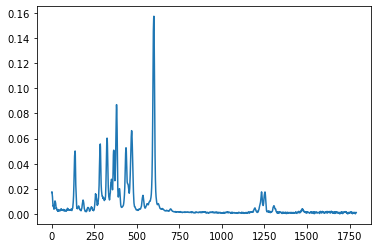

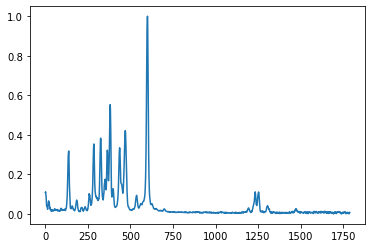

In [8]:
def normalize(s):
    """Normalize the input series from 0->1 and return it"""
    maxval = max(s)
    scale = 1 / maxval
    return([j * scale for j in s])

tst = JCAMP_reader("jdx/13735-12-1-IR.jdx")
plt.plot(tst['y'])
plt.show()
plt.plot(normalize(tst['y']))
plt.show()